In [62]:
# constants
PAYS_DATA = 'PaysData'

DATE_COL = 'Date'
COUNTRY_COL = 'Pays'
INFECTED_COL = 'Infection'
NEW_INFECTED_COL = 'InfectionNouvelles'
DEATH_COL = 'Deces'
RECOVERY_COL = 'Guerisons'
DEATH_RATE_COL = 'TauxDeces'
RECOVERY_RATE_COL = 'TauxGuerison'
INFECTED_RATE_COL = 'TauxInfection'
GROWTH_RATE_COL = 'TauxCroissance'

FRANCE = 'France'

In [41]:
# settings

URL = 'https://coronavirus.politologue.com/data/coronavirus/coronacsv.aspx?format=json'

chargement des données

In [89]:
import requests
from pymongo import MongoClient

client = None

def get_collection():
    global client
    if client is None:
        print('open new connection')
        client = MongoClient()    
    database = client.coco
    return database.per_country

def update_database():
    with requests.get(URL) as response:
        response.raise_for_status()
        data = response.json()
        
    collection = get_collection()
#     collection.delete_many({})
    data_per_country = data[PAYS_DATA]
    print(f'\t{len(data_per_country)} rows')
    for document in data_per_country:
        finder = {k:document[k] for k in document if k in [COUNTRY_COL, DATE_COL]}
        collection.find_one_and_replace(finder, document, upsert=True)
    print(f'\t{collection.count_documents({})} documents in collection')
    
update_database()

open new connection
	2465 rows
	2465 documents in collection


retraitement

In [90]:
def proccess_country_data(collection, country: str) -> None:
    country_data = collection.find({
        COUNTRY_COL: country
    })
    country_data = list(reversed(list(country_data)))
    
    [first_data, *country_data] = country_data
    perv_infected = first_data[INFECTED_COL]
    prev_new_infected = 0
    for day_data in country_data:
        new_infected = day_data[INFECTED_COL] - perv_infected
        growth_rate = 0 if prev_new_infected == 0 else new_infected / prev_new_infected
        collection.save({
            **day_data,
            NEW_INFECTED_COL: new_infected,
            GROWTH_RATE_COL: growth_rate
        })
        perv_infected = day_data[INFECTED_COL]
        prev_new_infected = new_infected

        
def process_countries():
    collection = get_collection()
    countries = collection.distinct(COUNTRY_COL)
    for country in countries:
        try:
            proccess_country_data(collection, country)
        except Exception as e:
            print(f'error occured with {country}: {e}')
    print('\tend processing')
            
process_countries()

/home/thomas/anaconda3/envs/coco/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: save is deprecated. Use insert_one or replace_one instead
  app.launch_new_instance()


	end processing


visualisation

	TauxCroissance    1.206361
dtype: float64


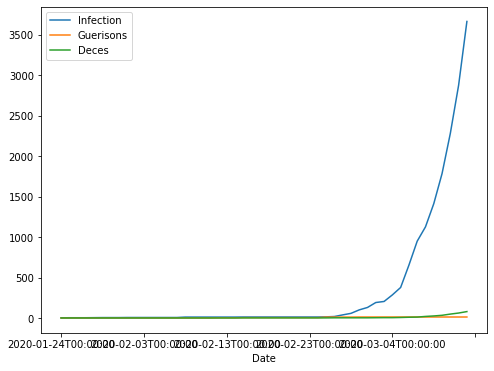

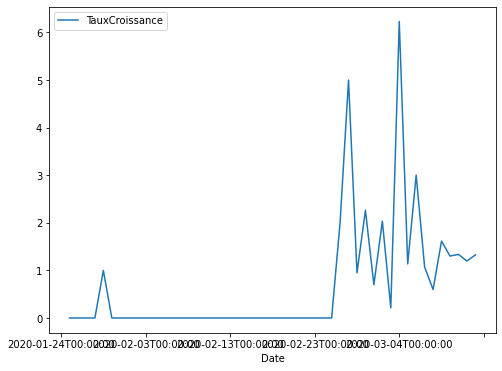

In [111]:
import numpy as np
import pandas as pd
from pymongo import MongoClient

def show_plot(df, columns):
        df.loc[:, columns].iloc[::-1].plot(x=DATE_COL, figsize=(8, 6))

def get_dataset_by_country(country: str) -> pd.DataFrame:
    collection = get_collection()
    data = collection.find({
        COUNTRY_COL: country
    })
    return pd.DataFrame(data)
        
def plot_by_country(country: str):
    dataset = get_dataset_by_country(country)
    print(f'\t{dataset.loc[:, [GROWTH_RATE_COL]].head(7).mean()}')
    show_plot(dataset, [INFECTED_COL, DATE_COL, RECOVERY_COL, DEATH_COL])
    show_plot(dataset, [DATE_COL, GROWTH_RATE_COL])
    
plot_by_country('France')